<a href="https://colab.research.google.com/github/Ken-huea/Time-series-analysis/blob/main/AR%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E5%AE%9F%E8%A3%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARMAモデル

自己回帰移動平均モデルと呼ばれ、MAモデルとARモデルを組み合わせたモデルである。

次数：p
次数：q



### MAモデル　p

移動平均モデル。「将来のYは過去の誤差によって説明される」
　「将来の予測値は、過去の予測値と実績値との誤差により決まる」

例えば、今月の売上量が、本来売上げる量より多かったら、来月は売上量が増える

次数：<font color="red">q</font>

過去どれだけ遡ると良くなるのかを試行する。

### ARモデル　q


自己回帰　「将来のYは、過去のYによって説明される」

「将来の予測値は、過去の予測値により決まる」、

例えば、今月の売上量が多かったら、来月は売上量が増える

次数：p

# ARモデルの実装
シンプル。そして思いのほか高性能



今回の目的：月ごとの平均気温の予測。

材料(変数)： 時系列､平均気温データ、ARMAモデル

### データの読み込み]


1.   読込
2.   カラムそぎ落とし
2.   groupby



今回使用するデータは、気温の時系列データです。

データ配布元：http://www.data.jma.go.jp/gmd/risk/obsdl/index.php

**まずは、理解を容易にするため、気温データのみを用います**

In [ ]:
#データの読込
import pandas as pd
weather_df = pd.read_csv("/content/ARモデルの実装.csv", encoding="shift-jis")

In [ ]:
#そして確認
weather_df.head(3)

,年月日,平均気温(℃),降水量の合計(mm),平均風速(m/s),日照時間(時間),平均現地気圧(hPa)
0,2015/1/1,3.7,0.0,4.4,1.3,1000.4
1,2015/1/2,2.7,0.0,2.1,6.0,1007.4
2,2015/1/3,3.8,0.0,3.0,8.9,1012.0


#### データ整形

In [ ]:
# 今回は練習の為、"年月日"と"平均気温(℃)"のカラムのみ使用致します。このようにしますと、任意のカラムのみ抽出する事が出来ます。

weather_df = weather_df[["年月日","平均気温(℃)"]]   # []を二重に
weather_df.head(5)

,年月日,平均気温(℃)
0,2015/1/1,3.7
1,2015/1/2,2.7
2,2015/1/3,3.8
3,2015/1/4,4.0
4,2015/1/5,6.9


In [ ]:
#infoも確認。
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   年月日      1827 non-null   object 
 1   平均気温(℃)  1827 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.7+ KB


infoにて確認した所、<font color="red">日付が文字列型</font>である事が確認できます。時系列データをindexに格納しましょう。

- 時系列解析の定石：時系列をdatetimeにしてindexに格納。

In [ ]:
# weather_df["年月日"]をdatetimeに変換した後、indexに格納します。
# それが完了したらカラムの["年月日"]はいらないのでドロップしましょう。
weather_df.index = pd.to_datetime(weather_df["年月日"], infer_datetime_format=True) 
weather_df = weather_df.drop(columns = ["年月日"])
weather_df.head(5)

# 上記のコードはこういうものなんだと割り切って頂ければ。

,平均気温(℃)
年月日,
2015-01-01,3.7
2015-01-02,2.7
2015-01-03,3.8
2015-01-04,4.0
2015-01-05,6.9


全ての範囲を月ごとの平均にしています。1月の平均気温/2月の平均気温... と。

⇒データ数の圧縮にもなりますし、いちいち一日毎の予測なんてしていられないでしょう。

In [ ]:
data = weather_df.resample("M").mean()
# data = weather_df.resample("W").mean() #⇒こうすれば1週間ごとになります。　お好みで。

data

,平均気温(℃)
年月日,
2015-01-31,5.783871
2015-02-28,5.717857
2015-03-31,10.251613
2015-04-30,14.523333
2015-05-31,21.100000
...,...
2019-09-30,25.060000
2019-10-31,19.425806
2019-11-30,13.100000


## 訓練データ・テストデータの分割
5対5でデータ分割



シンプルな分割方法を用います。train_test_splitも良いのですが、今回は変数とラベルが同一なので。

平均気温のデータから平均気温を予測しますよね。だからこの分割方法で十分です。

前半50%をトレイン、後半50%をテストとして分割しております。

In [ ]:
# データ数(len)*0.5をintに変換 その後に：で範囲を指定。 lenとintとlistの複合技です。

train=data[:int(len(data)*0.5)] # この長さまで。
test=data[int(len(data)*0.5):] # この長さ以降。

In [ ]:
#それぞれ確認してください。
train.head(5)
test.head(5)

,平均気温(℃)
年月日,
2017-07-31,27.319355
2017-08-31,26.448387
2017-09-30,22.806667
2017-10-31,16.825806
2017-11-30,11.943333


## モデル作成と学習

AR/ARMAモデルをそれぞれ作成する

In [ ]:
from statsmodels.tsa.ar_model import AR # モジュールインポート
model_ar = AR(train)                    # トレインデータを学習させる。

# モデルの学習
result_ar = model_ar.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


## 予測値の可視化とrmse算出

In [ ]:
# 予測⇒どの期間を予測するのかを確認しましょう。 ⇒ testとpredを日付のみ着目して双方とも合致していると確認しましょう。
pred = result_ar.predict("2017-07-31","2020-01-31")
print(test.tail(5))
print()
pred.tail(5)

              平均気温(℃)
年月日                  
2019-09-30  25.060000
2019-10-31  19.425806
2019-11-30  13.100000
2019-12-31   8.474194
2020-01-31   5.500000



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2019-09-30    25.181388
2019-10-31    20.315300
2019-11-30    14.289464
2019-12-31     8.763919
2020-01-31     5.317218
Freq: M, dtype: float64

上記のコードでpredに予測値が格納されました。それをtest_yと比較してみましょう。

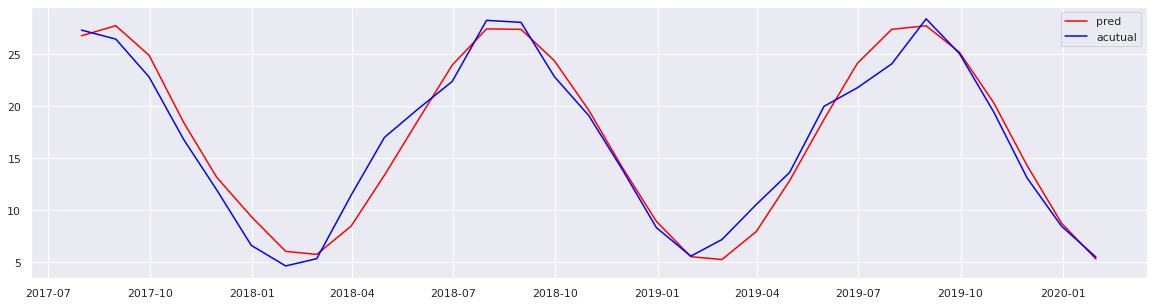

In [ ]:
# 可視化

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(20,5))

#1つ目のデータをplotメソッドでプロット
plt.plot(pred, color = 'red', label="pred")

#2つ目のデータをplotメソッドでプロット
plt.plot(test, color = 'blue',label="acutual")
plt.legend() # ラベルの表示
plt.show()

rmseでの確認もしてみましょう。　値が小さいほど良く予測できている、という事です。

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
# y_trainと予測値のRMSEを出す
print("RMSE",np.sqrt(MSE(test,pred)))

RMSE 1.6246677986471116
